## Getting started (Adjust settings to your experiment's needs)

In [1]:
import os
import sys
import logging
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from ir_measures import nDCG, AP, P, R, RR
from IRutils import dataprocessor, models, train, inference
from IRutils.dataset import TripletRankingDataset
from transformers import AutoTokenizer

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

dataset_name = "quora"  # SELECT YOUR EXPERIMENT DATASET HERE
model_name = "distilbert-base-uncased"  # SELECT YOUR MODEL HERE
"""
Some options:
DistilBERT: "distilbert-base-uncased" (66M params)
BERT: "bert-base-uncased" (110M params) or "bert-large-uncased" (340M params)
RoBERTa: "roberta-base" (125M params) or "roberta-large" (355M params)
ALBERT: "albert-base-v2" (12M params) or "albert-xxlarge-v2" (235M params)
ELECTRA: "google/electra-small-generator" (14M params) or "google/electra-base-generator" (110M params)
DeBERTa: "microsoft/deberta-base" (140M params) or "microsoft/deberta-v3-base" (184M params)
MPNet: "microsoft/mpnet-base" (110M params)
XLM-RoBERTa: "xlm-roberta-base" (125M params) or "xlm-roberta-large" (355M params)
T5: "t5-small" (60M params) or "t5-base" (220M params)
BART: "facebook/bart-base" (140M params) or "facebook/bart-large" (406M params)
LongFormer: "allenai/longformer-base-4096" (149M params)

For the distilled/smaller variants that are closer to DistilBERT in size and speed:

TinyBERT: "huawei-noah/TinyBERT_General_4L_312D" (15M params)
MobileBERT: "google/mobilebert-uncased" (25M params)
DistilRoBERTa: "distilroberta-base" (82M params)
"""
# Create dataset for a specific query length range (e.g., short queries)
"""
Options: 
short - 0-33 percentile (length)
medium - 33-67 percentile (length)
long - 67-100 percentile (length)
full - all data (sampled to one third)
"""
length_setting = 'short'

metrics = [nDCG@10, nDCG@100, AP@10, AP@100, P@10, R@10, P@100, R@100, RR]

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

logging.disable(logging.WARNING)

datasets = {'msmarco': ['train', 'dev'],
            'hotpotqa': ['train', 'dev', 'test'],
            'arguana': ['test'],
            'quora': ['dev', 'test'],
            'scidocs': ['test'],  # small
            'fever': ['train', 'dev', 'test'],  # large
            'climate-fever': ['test'],
            'scifact': ['train', 'test'],
            'fiqa': ['train', 'dev', 'test'],
            'nfcorpus': ['train', 'dev', 'test']
            }

max_len_doc = 512  # max token length
random_state = 42

C:\Users\chena\PycharmProjects\IR-rankingmodels\.venv\Lib\site-packages\beir\util.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Download and unzip the dataset
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
data_path = util.download_and_unzip(url, "datasets")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_available = False
if 'train' in datasets[dataset_name]:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="train")
    docs_test, queries_test, qrels_test = GenericDataLoader(data_folder=data_path).load(split="test")
    train_available = True
    print('Train and test set available!')
else:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    print('Only test set available!')

  0%|          | 0/522931 [00:00<?, ?it/s]

Only test set available!


In [3]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Data visualization

In [4]:
import numpy as np

def calculate_percentiles(query_lengths):
    # Calculate the percentiles
    t1 = np.percentile(query_lengths, 33)
    t2 = np.percentile(query_lengths, 67)
    return int(t1), int(t2)

t1: 8
t2: 10


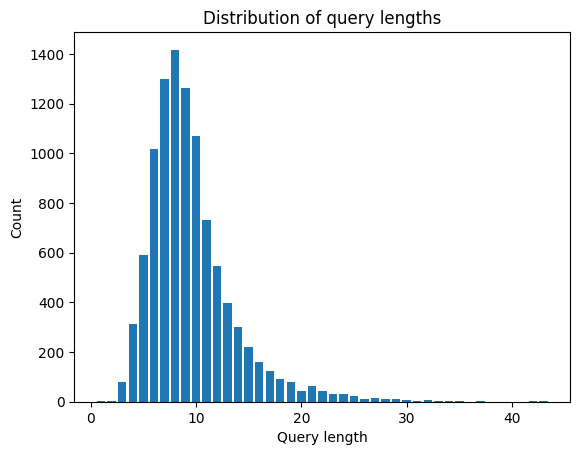

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

query_lengths = [len(txt.split()) for txt in list(queries.values())]
t1, t2 = calculate_percentiles(query_lengths)
print(f't1: {t1}')
print(f't2: {t2}')
ranges = {'short': (1, t1), 'medium': (t1, t2), 'long': (t2, sys.maxsize), 'full': (1, sys.maxsize)}

counts = Counter(query_lengths)
text_lengths = list(set(query_lengths))

counts = [counts[length] for length in text_lengths]
# Create bar chart
plt.bar(text_lengths, counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()


### Get test split (if no seperate test set available)

In [6]:
dp = dataprocessor.DataProcessor(queries, docs, qrels)

print(f'Dataset size: {len(queries)}')

# first seperate the test set (include queries of all lengths)
if not train_available:
    query_test, qrel_test = dp.get_testset(test_ratio=0.2, random_state=random_state)
    print(f'test size: {len(query_test)}')
else:
    print(f'test size: {len(queries_test)}')

Dataset size: 10000
test size: 2000


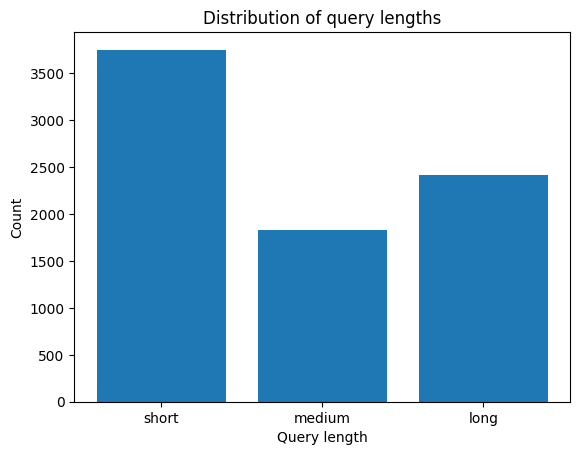

In [7]:
short = {qid: q for qid, q in dp.queries.items() if 0 < len(q.split()) <= ranges['short'][1]}
medium = {qid: q for qid, q in dp.queries.items() if ranges['medium'][0] < len(q.split()) <= ranges['medium'][1]}
long = {qid: q for qid, q in dp.queries.items() if ranges['long'][0] < len(q.split())}

counts = [len(short), len(medium), len(long)]

# Create bar chart
plt.bar(list(ranges.keys())[:3], counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()

### Query length filtering

In [8]:
# filter by query length
print(f'Length range: {ranges[length_setting]}')

full = True if length_setting == 'full' else False

query_subset, qrels_subset = dp.get_subset(ranges[length_setting][0], ranges[length_setting][1], full=full)  # Adjust min/max length

Length range: (1, 8)


### Train Val split

In [17]:
print(f'Example query from {length_setting} subset:\n{query_subset.popitem()}')

query_train, query_val, qrel_train, qrel_val = dp.train_val_split(train_ratio=0.8, val_ratio=0.2, random_state=42)  # adjust if needed

print(f'Length of subset of {length_setting} validation queries: {len(query_val)}')
print(f'Length of subset of {length_setting} training queries: {len(query_train)}')
print(f'Length of subset of {length_setting} queries: {len(query_subset)}')

Example query from short subset:
('537660', 'How did different races come about?')
Length of subset of short validation queries: 751
Length of subset of short training queries: 3000
Length of subset of short queries: 3751


### Distribution of training data

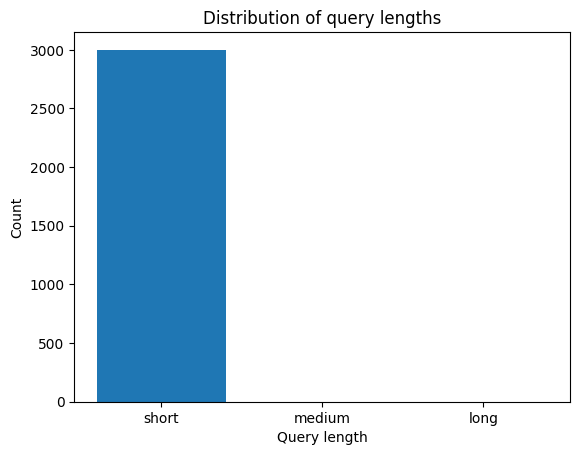

In [10]:
short = {qid: q for qid, q in query_train.items() if 1 < len(q.split()) <= ranges['short'][1]}
medium = {qid: q for qid, q in query_train.items() if ranges['medium'][0] < len(q.split()) <= ranges['medium'][1]}
long = {qid: q for qid, q in query_train.items() if ranges['long'][0] < len(q.split())}

counts = [len(short), len(medium), len(long)]

# Create bar chart
plt.bar(list(ranges.keys())[:3], counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()

### Check if the qrels already contain negative samples （If not create later)

In [11]:
qrel_scores = list(qrels.values()) 
relevance_scores = [list(item.values()) for item in qrel_scores]
num_negatives = relevance_scores[0].count(0)
print(f'Number of negatives in qrels: {num_negatives}')

Number of negatives in qrels: 0


### Create datasets and data loaders

In [12]:
print('Creating training dataset...')
train_dataset = TripletRankingDataset(query_train, docs, qrel_train, tokenizer, num_negatives, max_length=max_len_doc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print('Creating validation dataset...')
val_dataset = TripletRankingDataset(query_val, docs, qrel_val, tokenizer, num_negatives,max_length=max_len_doc)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

print('Creating testing dataset...')
if train_available:
    test_dataset = TripletRankingDataset(queries_test, docs_test, qrels_test, tokenizer, num_negatives,max_length=max_len_doc)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
else:
    test_dataset = TripletRankingDataset(query_test, docs, qrel_test, tokenizer, num_negatives,max_length=max_len_doc) 
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Creating training dataset...


100%|██████████| 3001/3001 [01:47<00:00, 27.91it/s]


Creating validation dataset...


100%|██████████| 751/751 [00:26<00:00, 28.37it/s]


Creating testing dataset...


100%|██████████| 2000/2000 [01:12<00:00, 27.73it/s]


### Initialize model

In [13]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.TripletRankerModel(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

os.makedirs(f'models/{model_name}/{dataset_name}', exist_ok=True)
model_path = os.path.join(os.getcwd(), f'models/{model_name}/{dataset_name}/{length_setting}_queries.pth')

### Train model (load directly if already trained)

In [14]:
print(model_path)
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    # Train the model
    model = train.train_triplet_ranker(model, train_loader, val_loader, optimizer, device, model_path)

C:\Users\chena\PycharmProjects\IR-rankingmodels\models/distilbert-base-uncased+quora+short_queries.pth


Epoch 1/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 1/10, Average Training Loss: 0.0315


Validation: 100%|██████████| 2605/2605 [04:09<00:00, 10.44it/s]


Validation Loss: 0.0201
Validation loss improved. Saving model.


Epoch 2/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 2/10, Average Training Loss: 0.0241


Validation: 100%|██████████| 2605/2605 [04:10<00:00, 10.39it/s]


Validation Loss: 0.0196
Validation loss improved. Saving model.


Epoch 3/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 3/10, Average Training Loss: 0.0361


Validation: 100%|██████████| 2605/2605 [04:14<00:00, 10.25it/s]

Validation Loss: 0.0642
Validation loss did not improve. Patience: 1/3


Epoch 4/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 4/10, Average Training Loss: 0.0422


Validation: 100%|██████████| 2605/2605 [04:00<00:00, 10.82it/s]


Validation Loss: 0.0132
Validation loss improved. Saving model.


Epoch 5/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 5/10, Average Training Loss: 0.0450


Validation: 100%|██████████| 2605/2605 [04:00<00:00, 10.81it/s]

Validation Loss: 0.0396
Validation loss did not improve. Patience: 1/3


Epoch 6/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 6/10, Average Training Loss: 0.0244


Validation: 100%|██████████| 2605/2605 [04:00<00:00, 10.82it/s]

Validation Loss: 0.0397
Validation loss did not improve. Patience: 2/3


Epoch 7/10 (Training):   0%|          | 0/10198 [00:00<?, ?it/s]

Epoch 7/10, Average Training Loss: 0.4222


Validation: 100%|██████████| 2605/2605 [04:00<00:00, 10.82it/s]


Validation Loss: 1.0000
Validation loss did not improve. Patience: 3/3
Early stopping triggered.
Loaded best model based on validation loss.
Training complete!


## Run inference on test set

In [15]:
# Example usage (replace with your data and model)
if train_available:
    metric_scores = inference.evaluate(model, test_loader, device, qrels_test)
else:
    metric_scores = inference.evaluate(model, test_loader, device, qrel_test)
    
for metric in metrics:
    print(f'Metric {metric} score: {metric_scores[metric]:.4f}')

Evaluating: 100%|██████████| 8163/8163 [12:38<00:00, 10.77it/s]


Metric nDCG@10 score: 0.7914
Metric nDCG@100 score: 0.8276
Metric AP@10 score: 0.7713
Metric AP@100 score: 0.7814
Metric P@10 score: 0.1265
Metric R@10 score: 0.8322
Metric P@100 score: 0.0153
Metric R@100 score: 0.9901
Metric RR score: 0.7849


## Write results to output

In [16]:
# Save results to a file
with open(f"results/{model_name}+{dataset_name}+{length_setting}_queries.txt", "w") as f:
    f.write(f"Evaluation Results for {model_name} model finetuned on {length_setting} queries from {dataset_name} dataset:\n")
    f.write(f"normalized Discounted Cumulative Gain@10: {metric_scores[nDCG@10]:.4f}\n")
    f.write(f"normalized Discounted Cumulative Gain@100: {metric_scores[nDCG@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"[Mean] Average Precision@10: {metric_scores[AP@10]:.4f}\n")
    f.write(f"[Mean] Average Precision@100: {metric_scores[AP@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"Precision@10: {metric_scores[P@10]:.4f}\n")
    f.write(f"Recall@10: {metric_scores[R@10]:.4f}\n")
    f.write(f"\n")
    f.write(f"Precision@100: {metric_scores[P@100]:.4f}\n")
    f.write(f"Recall@100: {metric_scores[R@100]:.4f}\n")
    f.write(f"\n")
    f.write(f"[Mean] Reciprocal Rank: {metric_scores[RR]:.4f}\n")
    f.write(f"\n")
    f.write(f"----------------------------------------------------\n")
    f.write(f"\n")
    f.write(f"Explanation of metrics:\n")
    f.write(f"NDCG@k (Normalized Discounted Cumulative Gain: Ranking Quality | Prioritizes highly relevant documents appearing earlier in the ranking.\n")
    f.write(f"MAP (Mean Average Precision): Overall Relevance | Measures ranking precision across all relevant documents. Best for small-scale retrieval tasks.\n")
    f.write(f"Precision@k: Relevance | Measures how many of the top-k documents are relevant. Works well in precision-sensitive applications.\n")
    f.write(f"Recall@k: Coverage | Measures how many relevant documents appear in the top-k results. Important in recall-sensitive tasks.\n")
    f.write(f"MRR (Mean Reciprocal Rank): Single Relevant Result | Focuses on ranking the first relevant document. Good for QA tasks.\n")